# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [6]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key
if weather_api_key == "YOUR KEY HERE!":
    import sys
    sys.path.append(r"C:\Users\nlund\Documents\GitHub\untracked_files")
    from api_keys_NRL import weather_api_key

print(weather_api_key)

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

b71963b5651be938ce326dc85e7b591d


## Generate Cities List

In [7]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

611

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [23]:
# Setup and call weather API

# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

# set up lists to hold reponse info
lat_list = []
lon_list = []
max_temp_list = []
humidity_list = []
cloudiness_list = []
wndspd_list = []
country_list = []
date_list = []
call_counter = 1
call_set = 1

# Collect weather data using json api calls
print('Beginning Data Retrieval')     
print('-----------------------------')

# Loop through the list of cities and perform a request for data on each and populate data lists
for city in cities:
    response = requests.get(query_url + city).json()
    #print(json.dumps(response, indent=4, sort_keys=True))

    try:
        lat_list.append(response['coord']['lon'])
        lon_list.append(response['coord']['lon'])
        max_temp_list.append(response['main']['temp_max'])
        humidity_list.append(response['main']['humidity'])
        cloudiness_list.append(response['clouds']['all'])
        wndspd_list.append(response['wind']['speed'])
        country_list.append(response['sys']['country'])
        date_list.append(response['dt'])

        print(f'Processing Record {call_counter} of Set {call_set} | {city}')

    except KeyError:
        print("City not found. Skipping...")

    if call_counter > 49:
        call_counter = 1
        call_set += 1
        time.sleep(10)    
    else:
        call_counter += 1

print('-----------------------------')
print('Data Retrieval Complete')      
print('-----------------------------')

Beginning Data Retrieval
-----------------------------
Processing Record 1 of Set 1 | banda aceh
Processing Record 2 of Set 1 | rikitea
Processing Record 3 of Set 1 | niort
Processing Record 4 of Set 1 | caravelas
Processing Record 5 of Set 1 | hilo
Processing Record 6 of Set 1 | yarensk
Processing Record 7 of Set 1 | kapaa
Processing Record 8 of Set 1 | mataura
Processing Record 9 of Set 1 | faanui
Processing Record 10 of Set 1 | albany
Processing Record 11 of Set 1 | lavrentiya
Processing Record 12 of Set 1 | hami
Processing Record 13 of Set 1 | pangnirtung
Processing Record 14 of Set 1 | manicore
Processing Record 15 of Set 1 | cacu
Processing Record 16 of Set 1 | ushuaia
Processing Record 17 of Set 1 | benjamin constant
Processing Record 18 of Set 1 | punta arenas
Processing Record 19 of Set 1 | ixtapa
Processing Record 20 of Set 1 | longyearbyen
Processing Record 21 of Set 1 | khatanga
Processing Record 22 of Set 1 | airai
Processing Record 23 of Set 1 | puerto ayora
City not foun

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [21]:
df_wx_data = pd.DataFrame({
    "City": cities[0],
    "Lat": lat_list,
    "Lng": lon_list,
    "Max Temp": max_temp_list,
    "Humidity": humidity_list,
    "Cloudiness": cloudiness_list,
    "Wind Speed": wndspd_list,
    "Country": country_list,
    "Date": date_list})
df_wx_data.to_csv(output_data_file)
df_wx_data

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,banda aceh,95.3222,95.3222,79.90,73,100,11.10,ID,1618861850
1,banda aceh,-134.9692,-134.9692,77.85,72,0,10.02,PF,1618861851
2,banda aceh,-0.3333,-0.3333,57.20,44,0,3.44,FR,1618861851
3,banda aceh,-39.2481,-39.2481,79.41,80,21,9.84,BR,1618861851
4,banda aceh,-155.0900,-155.0900,78.80,65,90,6.91,US,1618861617
...,...,...,...,...,...,...,...,...,...
557,banda aceh,-64.2615,-64.2615,89.64,35,52,11.90,AR,1618861888
558,banda aceh,-103.6833,-103.6833,86.00,16,20,8.68,MX,1618862118
559,banda aceh,-114.9819,-114.9819,84.99,4,1,4.61,US,1618861913
560,banda aceh,-117.7357,-117.7357,66.20,16,1,13.80,US,1618862119


### Display summary statistics on the weather DataFrame

In [24]:
df_wx_data.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,5.620000e+02
mean,19.940688,19.940688,60.770374,64.921708,50.628114,8.061851,1.618862e+09
std,90.814970,90.814970,22.608440,24.042986,40.161467,5.287085,9.820416e+01
min,-179.166700,-179.166700,-19.260000,4.000000,0.000000,0.400000,1.618862e+09
25%,-61.587550,-61.587550,46.570000,47.000000,6.000000,4.000000,1.618862e+09
50%,23.164450,23.164450,64.075000,70.000000,40.000000,6.910000,1.618862e+09
75%,97.405000,97.405000,79.265000,84.000000,92.000000,11.010000,1.618862e+09
max,179.316700,179.316700,100.400000,100.000000,100.000000,24.490000,1.618862e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

Nicole Lund: The dataset does not contain humidity > 100%. Skipping the removal of cities with this condition.

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,5.500000e+02
mean,19.973545,17.124400,58.331400,67.890909,52.141818,8.544800,1.585764e+09
std,33.284840,91.595451,25.795297,20.864881,35.766469,6.078869,5.539674e+01
min,-54.800000,-179.170000,-11.340000,9.000000,0.000000,0.160000,1.585764e+09
25%,-8.077500,-64.627500,42.800000,55.000000,20.000000,4.525000,1.585764e+09
50%,23.630000,19.635000,64.940000,72.000000,57.000000,7.325000,1.585764e+09
75%,48.672500,97.350000,78.800000,83.000000,86.750000,11.410000,1.585764e+09
max,78.220000,179.320000,102.200000,100.000000,100.000000,46.080000,1.585764e+09


In [17]:
#  Get the indices of cities that have humidity over 100%.


Int64Index([], dtype='int64')

In [19]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,butaritari,3.07,172.79,83.32,74,84,10.42,KI,1593605283
1,yerbogachen,61.28,108.01,79.52,58,20,7.70,RU,1593605121
2,cape town,-33.93,18.42,73.00,77,27,4.70,ZA,1593605039
3,touba,8.28,-7.68,79.97,75,82,3.58,CI,1593605284
4,jamestown,42.10,-79.24,64.00,88,1,6.93,US,1593605284


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [90]:
# Extract data collection date
pretty_date = []
for idx, row in df_wx_data.iterrows():
    data_time = time.localtime(row["Date"])
    pretty_date.append(f"{data_time.tm_mon}/{data_time.tm_mday}/{data_time.tm_year}")

collection_date = str(set(pretty_date)).strip("{'}")

## Latitude vs. Temperature Plot

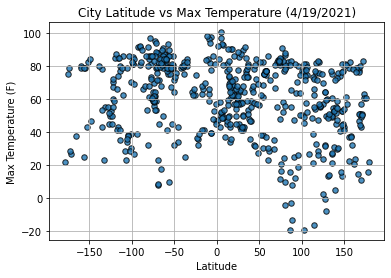

In [96]:
df_wx_data.plot(
    "Lat","Max Temp",
    title=f"City Latitude vs Max Temperature ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.savefig("output_data/lat_temp.png",facecolor='w')
plt.show()

The Latitude vs Max temperature plot shows the latitude for each city vs the maximum temperature seen that day.

## Latitude vs. Humidity Plot

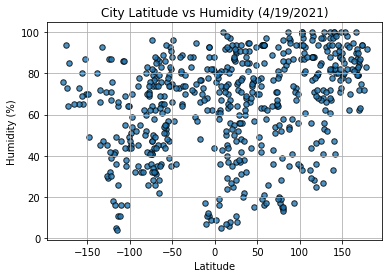

In [97]:
df_wx_data.plot(
    "Lat","Humidity",
    title=f"City Latitude vs Humidity ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.savefig("output_data/lat_humidity.png",facecolor='w')
plt.show()

The Latitude vs Humidity plot shows the latitude for each city vs the current humidity.

## Latitude vs. Cloudiness Plot

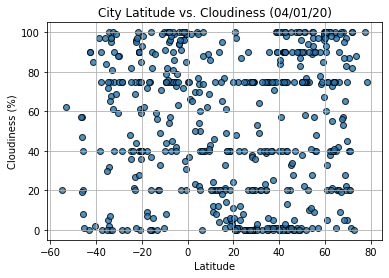

## Latitude vs. Wind Speed Plot

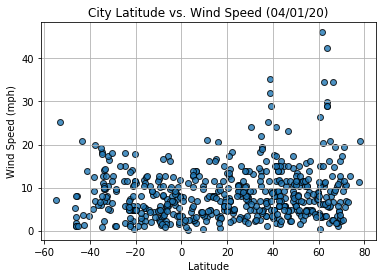

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.46937863826630627


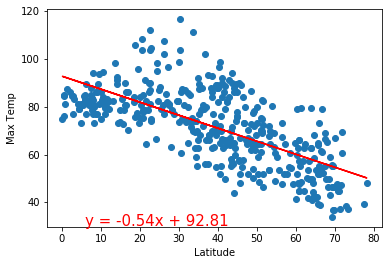

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.6082708688906918


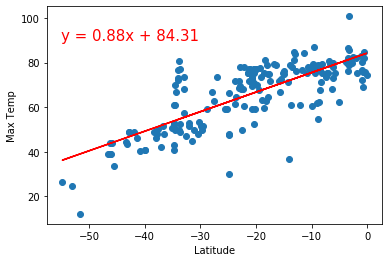

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.000543987878808455


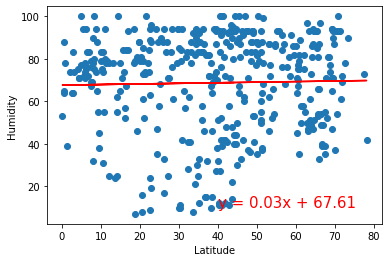

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.014985174297345524


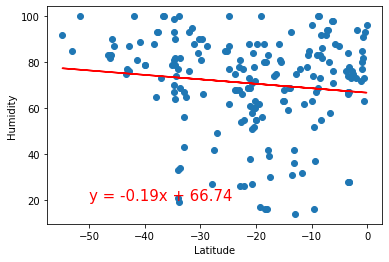

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.0020898727664228514


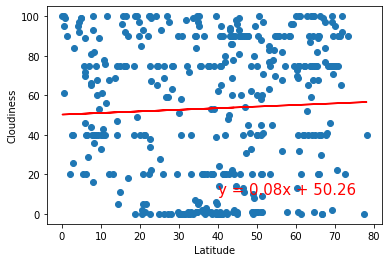

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.0035263772085582894


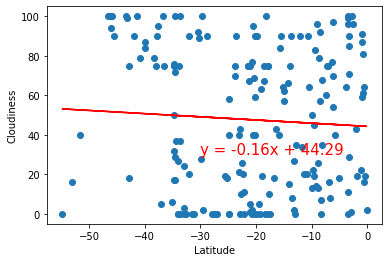

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.04019723576144484


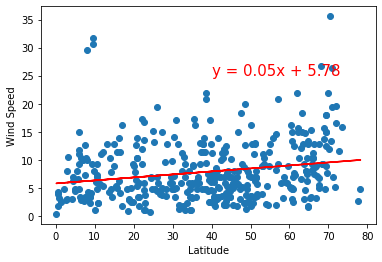

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.017128274759839232


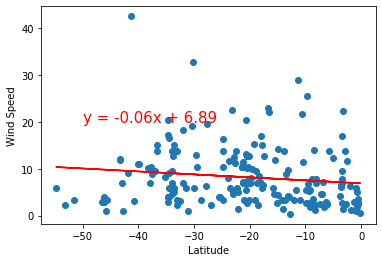